## AmExpert 2021 – Machine Learning Hackathon

### Problem Statement
* A mid-sized private bank that includes a variety of banking products, such as savings accounts, current accounts, investment products, credit products, and home loans. 
* The task is to predict the next set of products (upto 3 products) for a set of customers (test data) based on their demographics and current product holdings.midm

**Project Flow**
* Importing the data
* EDA
* Feature Engineering / Data Preparation
* Splitting the data to train and test
* Feature Scaling
* Model Building
* Model Evaluation
* Prediction on Given Test Set

### Importing the libraries

In [1]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval

# Data Preprocessing
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, KFold

# Model building
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

# Model Evaluation
from sklearn.metrics import multilabel_confusion_matrix, precision_score, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

### Data Exploration

In [2]:
# Loading the train & test datasets

# convert Target Variables to list while loading the csv using literal_eval
train_df = pd.read_csv('train_go05W65.csv', converters={"Product_Holding_B1": literal_eval, "Product_Holding_B2": literal_eval})
test_df = pd.read_csv('test_VkM91FT.csv', converters={"Product_Holding_B1": literal_eval})
sample_submission = pd.read_csv('sample_submission_kF044ur.csv')

In [3]:
# Training set
train_df.head()

,Customer_ID,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,Product_Holding_B1,Product_Holding_B2
0,CC264719,Male,41,14,0,C1,S3,[P16],[P8]
1,CC209679,Female,47,14,1,C1,S2,"[P13, P20]",[P3]
2,CC319633,Female,59,14,0,C2,S2,[P11],[P00]
3,CC231413,Female,32,16,0,C1,S2,"[P8, P13]",[P6]
4,CC259633,Male,30,15,0,C2,S3,"[P16, P17, P21]","[P8, P12]"


In [4]:
# Testing set
test_df.head()

,Customer_ID,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,Product_Holding_B1
0,CC372708,Female,31,31,0,C2,S3,"[P12, P13]"
1,CC216072,Male,28,37,1,C1,S2,"[P12, P13]"
2,CC387629,Male,31,12,0,C2,S3,[P20]
3,CC389228,Female,55,11,0,C2,S2,"[P13, P21]"
4,CC394445,Male,51,49,1,C2,S1,[P13]


In [5]:
train_df.info() # There are no null values in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37748 entries, 0 to 37747
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer_ID         37748 non-null  object
 1   Gender              37748 non-null  object
 2   Age                 37748 non-null  int64 
 3   Vintage             37748 non-null  int64 
 4   Is_Active           37748 non-null  int64 
 5   City_Category       37748 non-null  object
 6   Customer_Category   37748 non-null  object
 7   Product_Holding_B1  37748 non-null  object
 8   Product_Holding_B2  37748 non-null  object
dtypes: int64(3), object(6)
memory usage: 2.6+ MB


In [6]:
train_df.describe() # There are no outliers as the mean & median are almost similar 

,Age,Vintage,Is_Active
count,37748.000000,37748.000000,37748.000000
mean,38.521379,19.573169,0.264809
std,10.121811,10.252417,0.441237
min,24.000000,2.000000,0.000000
25%,29.000000,13.000000,0.000000
50%,37.000000,16.000000,0.000000
75%,47.000000,23.000000,1.000000
max,59.000000,65.000000,1.000000


In [7]:
# Analysis of categorical data
train_df.describe(include = 'object')

,Customer_ID,Gender,City_Category,Customer_Category,Product_Holding_B1,Product_Holding_B2
count,37748,37748,37748,37748,37748,37748
unique,37748,2,2,3,617,495
top,CC229841,Male,C1,S3,[P13],[P00]
freq,1,25890,18941,17865,7443,5908


### EDA

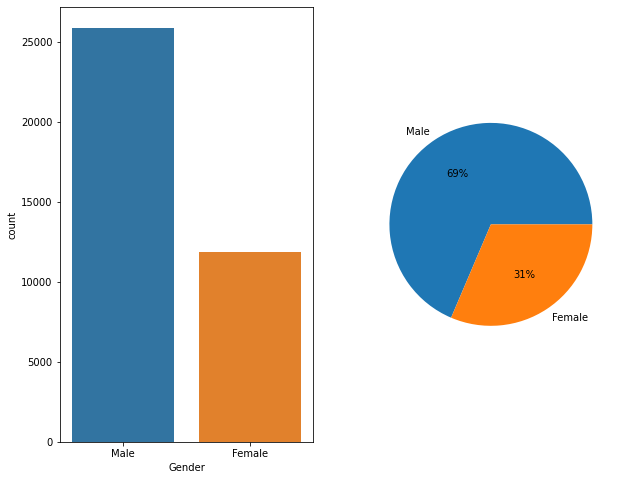

In [8]:
# Visualising the Gender Count
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
sns.countplot(train_df['Gender'], ax=ax[0])
ax[1].pie(train_df['Gender'].value_counts(), labels=['Male', 'Female'], autopct="%.0f%%")
fig.show()

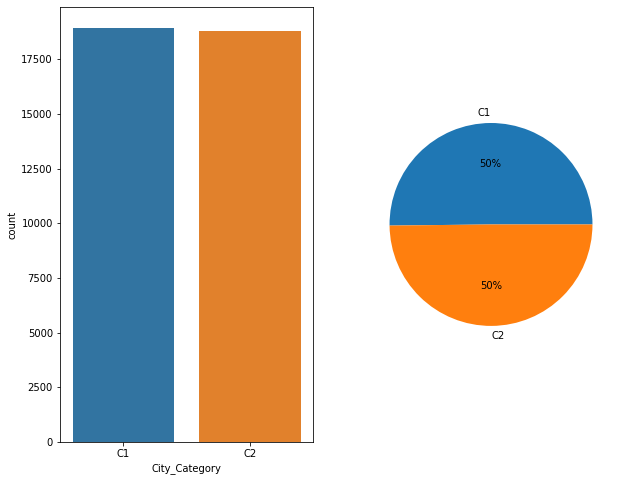

In [9]:
# Visualising the City_Category
fig, ax = plt.subplots(1,2, figsize = (10,8))
sns.countplot(train_df['City_Category'], ax=ax[0])
ax[1].pie(train_df['City_Category'].value_counts(), labels=['C1', 'C2'], autopct="%.0f%%")
fig.show()

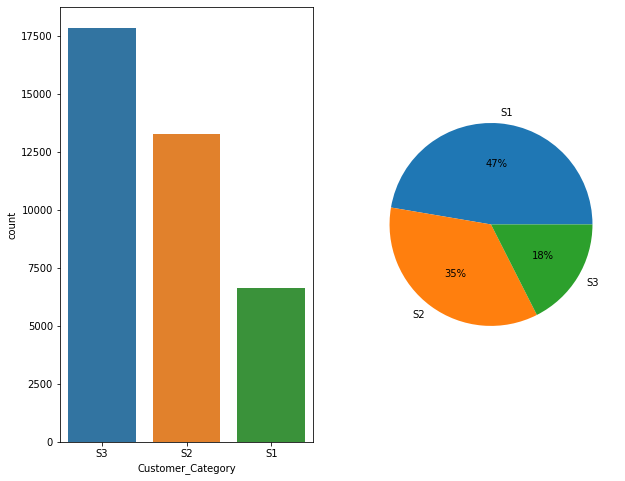

In [10]:
# Visualising the Customer_Category
fig, ax = plt.subplots(1,2, figsize = (10,8))
sns.countplot(train_df['Customer_Category'], ax=ax[0])
ax[1].pie(train_df['Customer_Category'].value_counts(), labels=['S1', 'S2', 'S3'], autopct="%.0f%%")
fig.show()

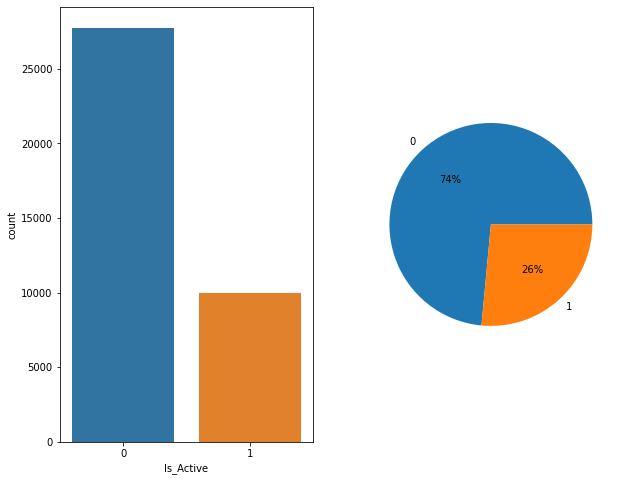

In [11]:
# Visualising the Is_Active
fig, ax = plt.subplots(1,2, figsize = (10,8))
sns.countplot(train_df['Is_Active'], ax=ax[0])
ax[1].pie(train_df['Is_Active'].value_counts(), labels=['0','1'], autopct="%.0f%%")
fig.show()

<AxesSubplot:xlabel='Age', ylabel='Count'>

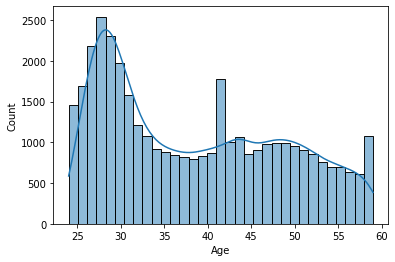

In [12]:
# Plot the Age histogram
sns.histplot(data=train_df, x='Age', kde=True)

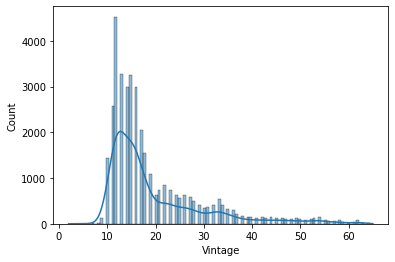

In [13]:
# Plot the Vintage histogram
sns.histplot(data=train_df, x='Vintage', kde=True)
plt.show()

<AxesSubplot:xlabel='Gender', ylabel='Age'>

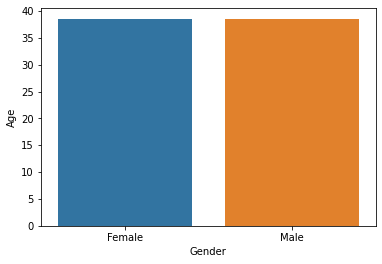

In [14]:
# Group by Gender and plot the mean Age
gender_data = train_df.groupby('Gender').mean().reset_index()
sns.barplot(x=gender_data['Gender'], y=gender_data['Age'])

**Both the genders have equal distribution in mean Age.**

<AxesSubplot:xlabel='Gender', ylabel='Vintage'>

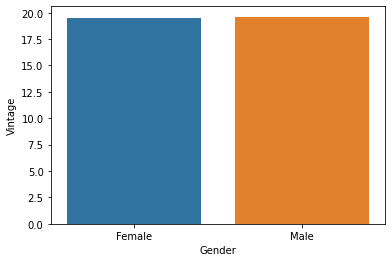

In [15]:
# Group by Gender and plot the mean Vintage
sns.barplot(x=gender_data['Gender'], y=gender_data['Vintage'])

**Both distributions have equal distribution of mean Vintage.**

In [16]:
# Insights across City Category
train_df.groupby('City_Category').mean()

,Age,Vintage,Is_Active
City_Category,,,
C1,38.340742,19.679003,0.274906
C2,38.703302,19.466582,0.254639


**Almost equal distributions of Age, Vintage and Is_Active observed across both the cities.**

In [17]:
# Insights across Customer_Category
train_df.groupby('Customer_Category').mean()

,Age,Vintage,Is_Active
Customer_Category,,,
S1,38.452856,19.077667,0.229526
S2,38.591481,19.495967,0.253449
S3,38.494710,19.814050,0.286314


**Almost equal distributions of Age, Vintage and Is_Active observed across both the Customer Cateogry.**

In [18]:
# Using Multi label Binarizer for converting Product_Holding_B1 column into numeric
mlb = MultiLabelBinarizer(sparse_output=False)
out_train = mlb.fit_transform(train_df['Product_Holding_B1'])

In [19]:
# Adding the converted columns to train dataset
train_df = train_df.join(pd.DataFrame(out_train, columns=mlb.classes_))
train_df.head()

,Customer_ID,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,Product_Holding_B1,Product_Holding_B2,P00,...,P2,P20,P21,P3,P4,P5,P6,P7,P8,P9
0,CC264719,Male,41,14,0,C1,S3,[P16],[P8],0,...,0,0,0,0,0,0,0,0,0,0
1,CC209679,Female,47,14,1,C1,S2,"[P13, P20]",[P3],0,...,0,1,0,0,0,0,0,0,0,0
2,CC319633,Female,59,14,0,C2,S2,[P11],[P00],0,...,0,0,0,0,0,0,0,0,0,0
3,CC231413,Female,32,16,0,C1,S2,"[P8, P13]",[P6],0,...,0,0,0,0,0,0,0,0,1,0
4,CC259633,Male,30,15,0,C2,S3,"[P16, P17, P21]","[P8, P12]",0,...,0,0,1,0,0,0,0,0,0,0


<AxesSubplot:>

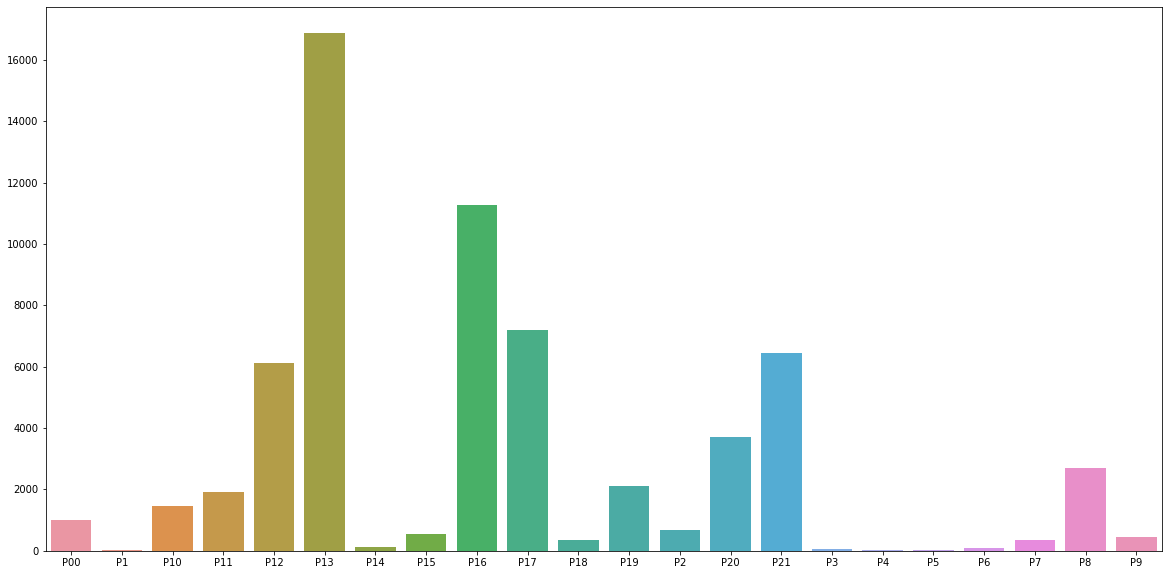

In [20]:
# Products 13, 16 & 17 are bought more
plt.figure(figsize=(20,10))
sns.barplot(x=mlb.classes_, y=train_df[mlb.classes_].sum())

In [21]:
train_df.iloc[:, 9:].sum(axis=1).value_counts()

1    19696
2    12421
3     3986
4     1242
5      320
6       71
7        9
8        3
dtype: int64

<AxesSubplot:>

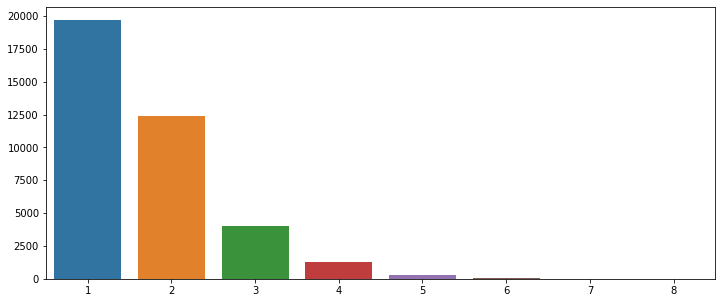

In [22]:
# We can see that combination of 1,2 & 3 products are bought more by the customers
plt.figure(figsize=(12, 5))
sns.barplot(x=[1, 2, 3, 4, 5, 6, 7, 8],y=train_df.iloc[:, 9:].sum(axis=1).value_counts())

In [23]:
# Target variable
# Converting Product_Holding_B2 column into numeric
mlb2 = MultiLabelBinarizer(sparse_output=False)
out_train_y = mlb2.fit_transform(train_df['Product_Holding_B2'])

In [24]:
# Creating different dataframe for target variables
target = pd.DataFrame(out_train_y, columns = mlb2.classes_)
target.head()

,P00,P1,P10,P11,P12,P13,P14,P15,P16,P17,P18,P2,P20,P3,P4,P5,P6,P7,P8,P9
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


<AxesSubplot:>

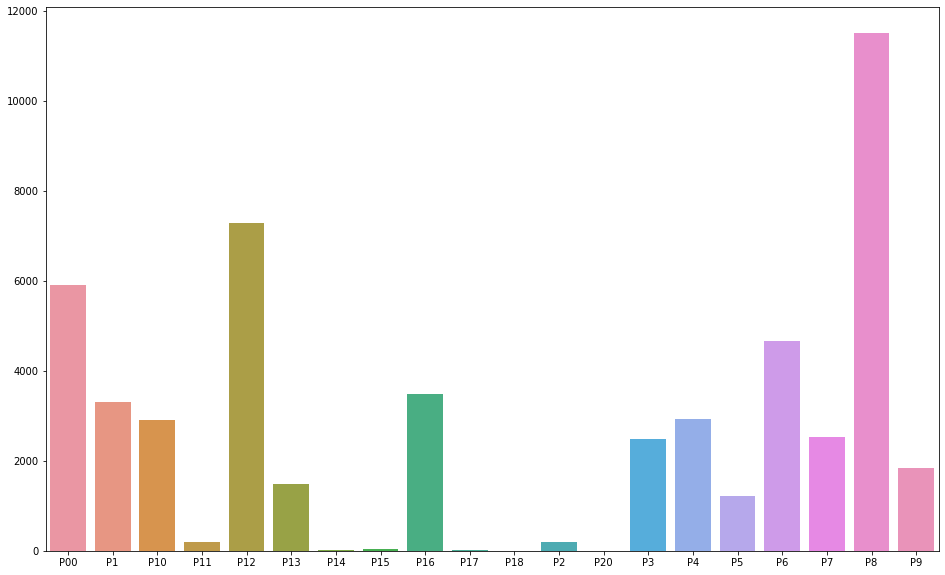

In [25]:
# Product 13, 16 & 17 are highly bought
plt.figure(figsize=(16,10))
sns.barplot(x=mlb2.classes_, y=target[mlb2.classes_].sum())

### Feature engineering/Data Preparation

In [26]:
# Columns with object datatype
columns_cat = train_df.select_dtypes(include='object')
columns_cat.head()

,Customer_ID,Gender,City_Category,Customer_Category,Product_Holding_B1,Product_Holding_B2
0,CC264719,Male,C1,S3,[P16],[P8]
1,CC209679,Female,C1,S2,"[P13, P20]",[P3]
2,CC319633,Female,C2,S2,[P11],[P00]
3,CC231413,Female,C1,S2,"[P8, P13]",[P6]
4,CC259633,Male,C2,S3,"[P16, P17, P21]","[P8, P12]"


In [27]:
# Converting categorical columns to numeric
train_df = pd.get_dummies(train_df, columns=['Gender', 'City_Category', 'Customer_Category'], drop_first=True)

In [28]:
# Removing columns which are not required
train_df = train_df.drop('Customer_ID', axis=1)
test_df = test_df.drop('Customer_ID', axis=1)

In [29]:
# Removing Product_Holding_B1 & Product_Holding_B2 columns
train_df = train_df.drop('Product_Holding_B1', axis=1)
train_df = train_df.drop('Product_Holding_B2', axis=1)

In [30]:
train_df.head()

,Age,Vintage,Is_Active,P00,P1,P10,P11,P12,P13,P14,...,P4,P5,P6,P7,P8,P9,Gender_Male,City_Category_C2,Customer_Category_S2,Customer_Category_S3
0,41,14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,47,14,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,59,14,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,32,16,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
4,30,15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1


In [31]:
test_df.head()

,Gender,Age,Vintage,Is_Active,City_Category,Customer_Category,Product_Holding_B1
0,Female,31,31,0,C2,S3,"[P12, P13]"
1,Male,28,37,1,C1,S2,"[P12, P13]"
2,Male,31,12,0,C2,S3,[P20]
3,Female,55,11,0,C2,S2,"[P13, P21]"
4,Male,51,49,1,C2,S1,[P13]


In [32]:
# Preparing test dataset

# Converting categorical columns to numeric
test_df = pd.get_dummies(test_df, columns=['Gender','City_Category','Customer_Category'], drop_first= True)

# Converting Product_Holding_B1 column into numeric
mlb = MultiLabelBinarizer(sparse_output=False)
test_df = test_df.join(pd.DataFrame(mlb.fit_transform(test_df['Product_Holding_B1']), columns = mlb.classes_))

# Removing Product_Holding_B1 columns 
test_df = test_df.drop('Product_Holding_B1', axis=1) 

In [33]:
test_df.head()

,Age,Vintage,Is_Active,Gender_Male,City_Category_C2,Customer_Category_S2,Customer_Category_S3,P00,P1,P10,...,P2,P20,P21,P3,P4,P5,P6,P7,P8,P9
0,31,31,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,28,37,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,31,12,0,1,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,55,11,0,0,1,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,51,49,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Spliting the data

In [34]:
# Creating X & Y variables
X= train_df
y = target

In [35]:
# Split the data into 80% train & 20% test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [36]:
# Checking shape of train & test 
print("X_train = {}".format(X_train.shape))
print("X_test = {}".format(X_test.shape))
print("y_train = {}".format(y_train.shape))
print("y_test = {}".format(y_test.shape))

X_train = (30198, 29)
X_test = (7550, 29)
y_train = (30198, 20)
y_test = (7550, 20)


### Scaling the data

In [37]:
# Scaling continuous columns (Age & Vintage) of train & test by using Normalization
col_scale = ['Age', 'Vintage']

for col in col_scale:
    scale = MinMaxScaler()
    train_df[col] = scale.fit_transform(train_df[col].values.reshape(-1, 1))
    test_df[col] = scale.transform(test_df[col].values.reshape(-1, 1))

### Model Building

##### Logistic

In [38]:
# Model Building
lr = LogisticRegression()
model_lr = MultiOutputClassifier(lr)
model_lr.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegression())

In [39]:
# Make Predictions and compute the precision at K
y_pred_prob_lr = model_lr.predict_proba(X_test)
y_pred_lr = model_lr.predict(X_test)

In [40]:
# Metrics
print('Accuracy : {}'.format(accuracy_score(y_test, y_pred_lr)))
print('Hamming loss : {}'.format(hamming_loss(y_test, y_pred_lr)))
print('Average precision score : {}'.format(average_precision_score(y_test, y_pred_lr, average='weighted')))

Accuracy : 0.2691390728476821
Hamming loss : 0.051754966887417216
Average precision score : 0.37818203475532663


##### XGBoost

In [41]:
# Model Building
xg = XGBClassifier(n_estimators=100,
                   max_depth=5,
                   random_state=10,
                   eta=0.01,
                   gamma=0.5,
                   learning_rate=0.1)
model_xg = MultiOutputClassifier(estimator=xg)
model_xg.fit(X_train, y_train)

[02:16:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:16:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:16:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:16:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None, eta=0.01,
                                              gamma=0.5, gpu_id=None,
                                              importance_type='gain',
                                              interaction_constraints=None,
                                              learning_rate=0.1,
                                              max_delta_step=None, max_depth=5,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=No

In [42]:
# Make Predictions and compute the precision at K
y_pred_prob_xg = model_xg.predict_proba(X_test)
y_pred_xg = model_xg.predict(X_test)

In [43]:
# Metrics
print('Accuracy : {}'.format(accuracy_score(y_test, y_pred_xg)))
print('Hamming loss : {}'.format(hamming_loss(y_test, y_pred_xg)))
print('Average precision score : {}'.format(average_precision_score(y_test, y_pred_xg, average='weighted')))

Accuracy : 0.27642384105960266
Hamming loss : 0.04990066225165563
Average precision score : 0.39504240909669647


##### Catboost

In [44]:
# Model Building
cat = CatBoostClassifier(iterations=10, random_state=10)
model_cat = MultiOutputClassifier(estimator=cat)
model_cat.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 0.3461234	total: 413ms	remaining: 3.72s
1:	learn: 0.2687908	total: 451ms	remaining: 1.8s
2:	learn: 0.2433971	total: 475ms	remaining: 1.11s
3:	learn: 0.2277984	total: 496ms	remaining: 744ms
4:	learn: 0.2236922	total: 512ms	remaining: 512ms
5:	learn: 0.2212444	total: 527ms	remaining: 351ms
6:	learn: 0.2171265	total: 545ms	remaining: 234ms
7:	learn: 0.2153789	total: 561ms	remaining: 140ms
8:	learn: 0.2140783	total: 577ms	remaining: 64.1ms
9:	learn: 0.2132406	total: 592ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.2896666	total: 25.8ms	remaining: 232ms
1:	learn: 0.2349078	total: 44.2ms	remaining: 177ms
2:	learn: 0.2178854	total: 57.5ms	remaining: 134ms
3:	learn: 0.2105916	total: 71.6ms	remaining: 107ms
4:	learn: 0.2083504	total: 84.6ms	remaining: 84.6ms
5:	learn: 0.2069919	total: 97.5ms	remaining: 65ms
6:	learn: 0.2053720	total: 111ms	remaining: 47.6ms
7:	learn: 0.2045286	total: 124ms	remaining: 31.1ms
8:	learn: 0.2036785	total: 137ms	remaining: 

9:	learn: 0.1025281	total: 174ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.3747488	total: 22ms	remaining: 198ms
1:	learn: 0.3061775	total: 43.4ms	remaining: 174ms
2:	learn: 0.2838178	total: 67.4ms	remaining: 157ms
3:	learn: 0.2745875	total: 87.7ms	remaining: 132ms
4:	learn: 0.2722067	total: 109ms	remaining: 109ms
5:	learn: 0.2705385	total: 135ms	remaining: 89.8ms
6:	learn: 0.2687703	total: 154ms	remaining: 66.1ms
7:	learn: 0.2656760	total: 178ms	remaining: 44.4ms
8:	learn: 0.2639169	total: 200ms	remaining: 22.3ms
9:	learn: 0.2631661	total: 222ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.2636855	total: 25.4ms	remaining: 229ms
1:	learn: 0.2049207	total: 48.1ms	remaining: 192ms
2:	learn: 0.1805913	total: 76.5ms	remaining: 179ms
3:	learn: 0.1731302	total: 98.5ms	remaining: 148ms
4:	learn: 0.1695596	total: 125ms	remaining: 125ms
5:	learn: 0.1682555	total: 148ms	remaining: 98.3ms
6:	learn: 0.1671692	total: 174ms	remaining: 74.8ms
7:	learn: 0.1665304	total: 197ms	remaining

MultiOutputClassifier(estimator=<catboost.core.CatBoostClassifier object at 0x000001F08A178B50>)

In [45]:
# Make Predictions and compute the precision at K
y_pred_prob_cat = model_cat.predict_proba(X_test)
y_pred_cat = model_cat.predict(X_test)

In [46]:
# Metrics
print('Accuracy : {}'.format(accuracy_score(y_test, y_pred_cat)))
print('Hamming loss : {}'.format(hamming_loss(y_test, y_pred_cat)))
print('Average precision score : {}'.format(average_precision_score(y_test, y_pred_cat, average='weighted')))

Accuracy : 0.26543046357615896
Hamming loss : 0.05037086092715232
Average precision score : 0.38661856603872014


##### ANN Model

In [47]:
# Neural Network (NN)

# Creating the Model
model = Sequential()
model.add(Dense(units=32, activation='relu',
                kernel_initializer='uniform', input_shape=[X_train.shape[1]]))
model.add(Dense(units=16, activation='relu', kernel_initializer='normal'))
model.add(Dense(units=8, activation='relu', kernel_initializer='normal'))
model.add(Dense(units=target.shape[1], activation='sigmoid'))

In [48]:
# Model optimization.
# Loss : It is more natural to use BinaryCrossEntropy loss for this multi category
# Optimizer : Using Adam for a faster learning.

# Compile the model and train it with the training data.
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_test, y_test),
                    epochs=200,
                    verbose=0,
                    batch_size=32)

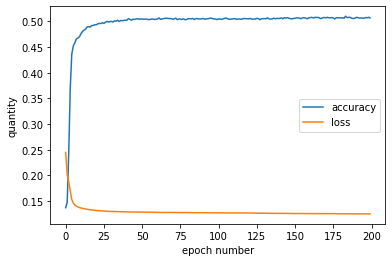

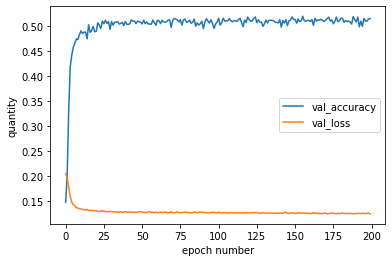

In [49]:
# Plot the results of training.
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.xlabel('epoch number')
plt.ylabel('quantity')
plt.legend()
plt.show()

# Plot the results of testing
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('epoch number')
plt.ylabel('quantity')
plt.legend()
plt.show()

In [50]:
# Make Predictions and compute the precision at K
y_pred_prob_ANN = model.predict_proba(X_test)
y_pred_ANN = model.predict(X_test)

In [51]:
# Metrics
#print('Accuracy : {}'.format(accuracy_score(y_test, y_pred_ANN)))
#print('Hamming loss : {}'.format(hamming_loss(y_test, y_pred_ANN)))
print('Average precision score : {}'.format(average_precision_score(y_test, y_pred_ANN, average='weighted')))

Average precision score : 0.6147584650081355


In [52]:
#compare_score = 

**Going ahead with ANN model as it is giving highest Average precision score.**

### Prediction 

#### Predictions on training

In [53]:
# creation of dictionary for predicting Y variable
int_char = dict((i, c) for i, c in enumerate(y_train))

prediction = []
for i in range(len(X_test)):
    # highest probablity will have zero rank
    rank = np.argsort(y_pred_prob_ANN[i])

    # -> pic the top 3 Probabilities
    top_3_proba = ([i for i in rank])[-3:]

    pred = [int_char[x] for x in top_3_proba]
    prediction.append(pred)

In [54]:
prediction

[['P5', 'P1', 'P4'],
 ['P3', 'P7', 'P6'],
 ['P10', 'P6', 'P8'],
 ['P12', 'P6', 'P8'],
 ['P10', 'P8', 'P12'],
 ['P8', 'P4', 'P10'],
 ['P6', 'P8', 'P00'],
 ['P4', 'P1', 'P00'],
 ['P00', 'P13', 'P16'],
 ['P6', 'P3', 'P8'],
 ['P12', 'P8', 'P00'],
 ['P00', 'P9', 'P8'],
 ['P1', 'P8', 'P12'],
 ['P4', 'P6', 'P8'],
 ['P8', 'P1', 'P00'],
 ['P6', 'P00', 'P8'],
 ['P10', 'P8', 'P12'],
 ['P7', 'P6', 'P8'],
 ['P3', 'P7', 'P6'],
 ['P10', 'P6', 'P8'],
 ['P1', 'P8', 'P00'],
 ['P12', 'P6', 'P8'],
 ['P12', 'P8', 'P00'],
 ['P12', 'P8', 'P00'],
 ['P1', 'P12', 'P00'],
 ['P6', 'P1', 'P8'],
 ['P3', 'P8', 'P12'],
 ['P7', 'P3', 'P6'],
 ['P1', 'P8', 'P00'],
 ['P8', 'P12', 'P13'],
 ['P9', 'P1', 'P8'],
 ['P8', 'P1', 'P00'],
 ['P6', 'P00', 'P8'],
 ['P8', 'P1', 'P00'],
 ['P10', 'P4', 'P8'],
 ['P4', 'P7', 'P6'],
 ['P8', 'P12', 'P00'],
 ['P6', 'P8', 'P00'],
 ['P6', 'P1', 'P3'],
 ['P12', 'P8', 'P00'],
 ['P8', 'P4', 'P10'],
 ['P10', 'P8', 'P12'],
 ['P9', 'P1', 'P8'],
 ['P3', 'P7', 'P6'],
 ['P3', 'P8', 'P12'],
 ['P00', 'P

#### Predictions on test data

In [55]:
#### Predictions on test data
pred_test = model.predict_proba(test_df)

In [56]:
prediction_test = []
for i in range(len(test_df)):

    # highest probablity will have zero rank
    rank = np.argsort(pred_test[i])
    
    # -> pic the top 3 Probabilities
    top_3_proba = ([i for i in rank])[-3:]  

    pred = [int_char[x] for x in top_3_proba]
    prediction_test.append(pred)

In [57]:
prediction_test

[['P3', 'P1', 'P00'],
 ['P6', 'P4', 'P8'],
 ['P4', 'P3', 'P1'],
 ['P1', 'P3', 'P00'],
 ['P4', 'P1', 'P00'],
 ['P1', 'P3', 'P00'],
 ['P4', 'P1', 'P00'],
 ['P4', 'P3', 'P1'],
 ['P4', 'P1', 'P00'],
 ['P7', 'P1', 'P3'],
 ['P3', 'P4', 'P1'],
 ['P4', 'P1', 'P00'],
 ['P7', 'P3', 'P1'],
 ['P1', 'P3', 'P00'],
 ['P3', 'P1', 'P00'],
 ['P4', 'P3', 'P1'],
 ['P4', 'P7', 'P8'],
 ['P00', 'P1', 'P3'],
 ['P3', 'P1', 'P00'],
 ['P3', 'P1', 'P00'],
 ['P1', 'P3', 'P00'],
 ['P1', 'P3', 'P00'],
 ['P4', 'P1', 'P6'],
 ['P3', 'P1', 'P00'],
 ['P3', 'P1', 'P00'],
 ['P4', 'P3', 'P1'],
 ['P3', 'P2', 'P00'],
 ['P2', 'P6', 'P8'],
 ['P7', 'P3', 'P8'],
 ['P3', 'P1', 'P8'],
 ['P6', 'P1', 'P00'],
 ['P4', 'P1', 'P00'],
 ['P3', 'P1', 'P00'],
 ['P1', 'P3', 'P00'],
 ['P4', 'P10', 'P8'],
 ['P9', 'P11', 'P8'],
 ['P4', 'P1', 'P2'],
 ['P00', 'P3', 'P1'],
 ['P3', 'P1', 'P8'],
 ['P3', 'P1', 'P00'],
 ['P4', 'P3', 'P1'],
 ['P4', 'P3', 'P1'],
 ['P1', 'P3', 'P00'],
 ['P4', 'P1', 'P00'],
 ['P3', 'P1', 'P00'],
 ['P1', 'P3', 'P00'],
 ['P1